In [1]:
import xarray as xr
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [2]:
############################
# set up 
############################
#
#feature_data          = '/glade/work/hardt/ds612/model2_00minuteAfterHour_3D_refl_scaled-test.nc'
#label_data            = '/glade/work/hardt/ds612/model2_composite_W_scaled-test.nc'
feature_data          = '/glade/work/hardt/ds612/model2_00minuteAfterHour_3D_refl_shuffled_scaled-train.nc'
label_data            = '/glade/work/hardt/ds612/model2_composite_W_shuffled_scaled-train.nc'
#
W_data_main_path = '/glade/work/hardt/ds612'
W_ds = xr.open_dataset(os.path.join(W_data_main_path, "model2_2012-2015_3D_W.nc"))
#
W_train_t = W_ds.XTIME[:3671].values
W_train = W_ds.W[:3671,:,:,:].values.max(axis=1)
#
refl_data_main_path = '/glade/work/hardt/ds612'
ifile = 'model2_2012-2015_00minuteAfterHour_3D_refl.nc'
refl_ds = xr.open_dataset( os.path.join(refl_data_main_path, ifile) )
#
refl_train   = refl_ds.REFL_10CM[:3671,:,:,:].values.max(axis=1)
refl_train_t = refl_ds.XTIME[:3671].values

In [3]:
fds = xr.open_dataset(feature_data)
f = fds.REFL_10CM.values

lds = xr.open_dataset(label_data)
l = lds.W.values

In [4]:
s = fds.shuffle_seq.values

In [5]:
W_train = W_train[s]
refl_train = refl_train[s]

In [6]:
W_train_t = W_train_t[s]
refl_train_t = refl_train_t[s]

In [23]:
print(f.shape)
print(l.shape)
print(W_train.shape)
print(refl_train.shape)
print(np.amin(W_train))
print(np.amax(W_train))
print(np.percentile(W_train, 99.0))

(3671, 10, 256, 256)
(3671, 256, 256)
(3671, 256, 256)
(3671, 256, 256)
-0.0061284434
37.576614
1.066135632991788


In [8]:
f2d = np.max(f[:,:,:,:], axis=1)
print(f2d.shape)

(3671, 256, 256)


In [9]:
#
# set up lat lon arrays
#
input_dir = '/glade/work/hardt/ds612'
#
latlon_filename = 'model2_latlon_coord.nc'
latlonFile = os.path.join(input_dir, latlon_filename)
#
latlon_ds = xr.open_mfdataset(latlonFile, combine='by_coords')
lat = latlon_ds.XLAT[0,:,:].values
lon = latlon_ds.XLONG[0,:,:].values

In [33]:
plt_number = 236
fi = f2d[plt_number,:,:]
li = l[plt_number,:,:]
wi = W_train[plt_number,:,:]
ri = refl_train[plt_number,:,:]

#li = li * (lmax - lmin) + lmin
#pi = pi * (lmax - lmin) + lmin

#
#get the data time string
#
#refl_train_t = refl_ds.XTIME[plt_number].values
print(refl_train_t[plt_number])
#
#W_train_t = W_ds.XTIME[plt_number].values
print(W_train_t[plt_number])
#
l_t = lds.XTIME[plt_number].values
print(l_t)
#
year = str(l_t)[0:4]
month = str(l_t)[5:7]
day = str(l_t)[8:10]
hour = str(l_t)[11:13]
minute = str(l_t)[14:16]
full_datetime_string = year + month + day + " " + hour + ':' + minute + ' ' + 'UTC'
yearMonthDay = year + month + day
print(full_datetime_string)

2014-08-30T15:00:00.000000000
2014-08-30T15:00:00.000000000
2014-08-30T15:00:00.000000000
20140830 15:00 UTC


In [34]:
#
# changes to the colormap
#
from matplotlib.colors import ListedColormap

cmap = plt.cm.get_cmap('Spectral_r', 256)
newcolors = cmap(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
lt_gray = np.array([240/256, 240/256, 240/256, 1])
newcolors[:1, :] = lt_gray
mycmap = ListedColormap(newcolors)
#print(newcmap(range(12)))
#print('newcmap(np.linspace(0, 1, 12))', newcmp(np.linspace(0, 1, 12)))

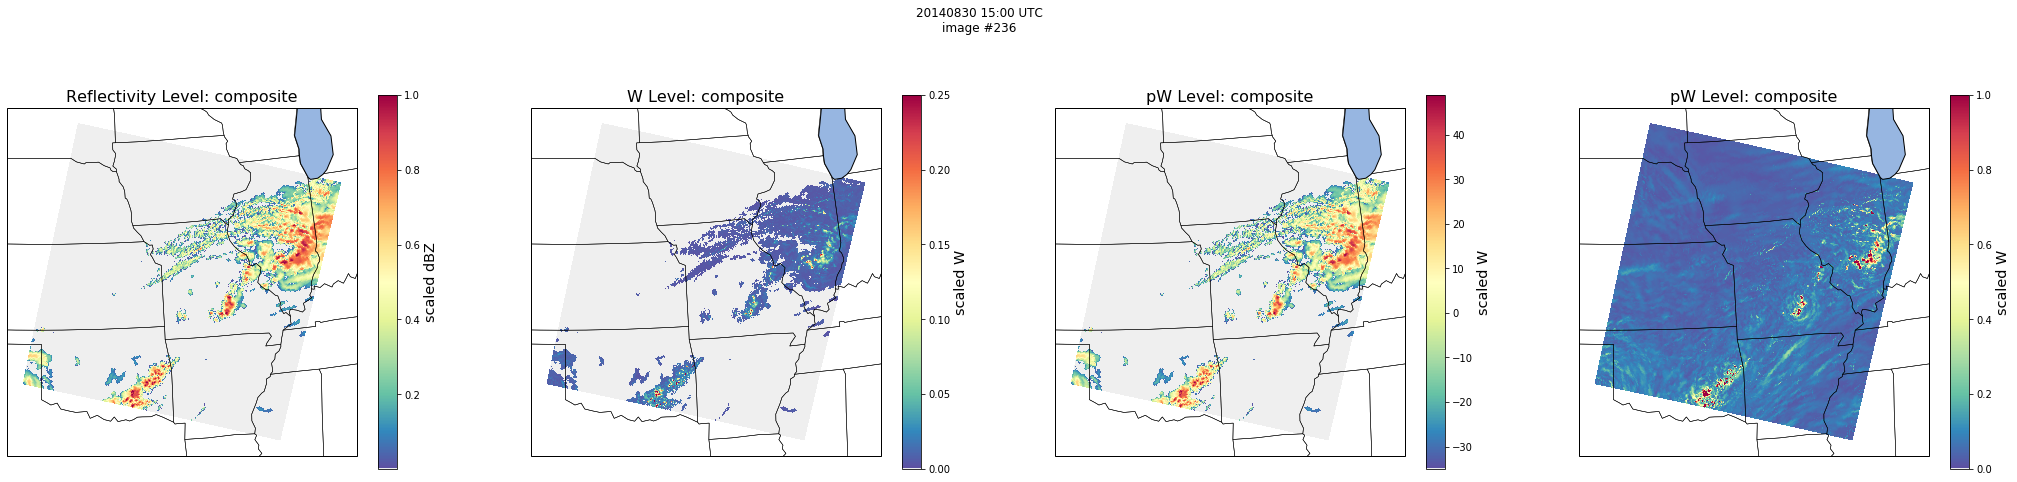

In [35]:
import cartopy.crs as ccrs
import cartopy.feature as cf

composite_refl = True
composite_W = True

#
# images with geo-referencing
#

def plot_background(ax):
    #ax.set_extent([235., 290., 20., 55.])
    #ax.set_extent([-102, -85, 30, 45])
    ax.add_feature(cf.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cf.STATES, linewidth=0.5)
    ax.add_feature(cf.BORDERS, linewidth=0.5)
    ax.add_feature(cf.OCEAN)
    ax.add_feature(cf.LAKES, edgecolor='black')
    ax.add_feature(cf.LAND, facecolor='white', edgecolor='none')
    #ax.add_feature(cf.LAND, facecolor='wheat', edgecolor='none')

    return ax

#
# set up plot
#
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
#
#cmap = plt.cm.Spectral_r
cmap=mycmap
#
fig, axarr = plt.subplots(nrows=1, ncols=4, figsize=(36, 8), subplot_kw={'projection': crs})
fig.suptitle(full_datetime_string + '\nimage #' + str(plt_number))
#
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
#
# fi (feature image)
#
if composite_refl:
    cf1 = axlist[0].pcolormesh(lon, lat, fi, cmap=cmap, transform = ccrs.PlateCarree())
    axlist[0].set_title('Reflectivity Level: composite', fontsize=16)
else:
    cf1 = axlist[0].pcolormesh(lon, lat, fi, cmap=cmap, transform = ccrs.PlateCarree())
    axlist[0].set_title('Reflectivity Level: ' + str(refl_height+1) + ' of 10', fontsize=16)
#
cb1 = fig.colorbar(cf1, ax=axlist[0], orientation='vertical', shrink=0.86, pad=0.05)#, cmap=cmap)#, norm=norm, ticks=bounds)
#
#########################################
# adjusting the colorscale
#
cb1.mappable.set_clim(0.001,1)
cb1.set_label('scaled dBZ', size='x-large')
#########################################
#
#
# Plotting li (label image)
#
cf2 = axlist[1].pcolormesh(lon, lat, li, cmap=cmap, transform = ccrs.PlateCarree())
if composite_W:
    axlist[1].set_title('W Level: composite', fontsize=16)
else:
    axlist[1].set_title('W Level: ' + str(W_height+1) + ' of 51', fontsize=16)
#
cb2 = fig.colorbar(cf2, ax=axlist[1], orientation='vertical', shrink=0.86, pad=0.05, 
                   cmap=cmap)#, norm=norm, ticks=bounds, extend='both', boundaries=[-10] + bounds + [10], spacing='uniform', extendfrac='auto')
#
#########################################
# adjusting the colorscale
#
cb2.mappable.set_clim(0,.25)
cb2.set_label('scaled W', size='x-large')
#########################################
#
#
# Plotting ri (unscaled refl composite image)
#
cf3 = axlist[2].pcolormesh(lon, lat, ri, cmap=cmap, transform = ccrs.PlateCarree())
if composite_W:
    axlist[2].set_title('pW Level: composite', fontsize=16)
else:
    axlist[2].set_title('pW Level: ' + str(W_height+1) + ' of 51', fontsize=16)
#
cb3 = fig.colorbar(cf3, ax=axlist[2], orientation='vertical', shrink=0.86, pad=0.05, 
                   cmap=cmap)#, norm=norm, ticks=bounds, extend='both', boundaries=[-10] + bounds + [10], spacing='uniform', extendfrac='auto')
#
#########################################
# adjusting the colorscale
#
cb3.mappable.set_clim()
cb3.set_label('scaled W', size='x-large')
#########################################
#
#
# Plotting wi (unscaled W composite image)
#
cf4 = axlist[3].pcolormesh(lon, lat, wi, cmap=cmap, transform = ccrs.PlateCarree())
if composite_W:
    axlist[3].set_title('pW Level: composite', fontsize=16)
else:
    axlist[3].set_title('pW Level: ' + str(W_height+1) + ' of 51', fontsize=16)
#
cb4 = fig.colorbar(cf4, ax=axlist[3], orientation='vertical', shrink=0.86, pad=0.05, 
                   cmap=cmap)#, norm=norm, ticks=bounds, extend='both', boundaries=[-10] + bounds + [10], spacing='uniform', extendfrac='auto')
#
#########################################
# adjusting the colorscale
#
cb4.mappable.set_clim(0,1)
cb4.set_label('scaled W', size='x-large')
#########################################
#